![](https://cdn-images-1.medium.com/max/1600/1*yZ1LPIcXnnW6Ubmp2M-0rQ.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_users_2.csv', 'countries.csv', 'test_users.csv', 'sessions.csv', 'sample_submission_NDF.csv', 'age_gender_bkts.csv', 'sample_submission.csv']


In [2]:
data_train = pd.read_csv('../input/train_users_2.csv',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
data_test = pd.read_csv('../input/test_users.csv',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
data_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
data_test.head()
# Note that 'date_first_booking' is completely missing in test data

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01 00:00:06,NaT,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,2014-07-01 00:00:51,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,2014-07-01 00:01:48,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,2014-07-01 00:02:15,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,2014-07-01 00:03:05,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [4]:
# Note incorrect minimum and maximum age values
data_train.describe()

,age,signup_flow
count,125461.000000,213451.000000
mean,49.668335,3.267387
std,155.666612,7.637707
min,1.000000,0.000000
25%,28.000000,0.000000
50%,34.000000,0.000000
75%,43.000000,0.000000
max,2014.000000,25.000000


In [5]:
print ('Number of lines in the training data are,',data_train.shape[0])

Number of lines in the training data are, 213451


In [6]:
countries = pd.read_csv('../input/countries.csv')
countries.head(10)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [7]:
test_ids = data_test['id']
Nrows_train = data_train.shape[0]  

# Store country names
labels = data_train['country_destination'].values
data_train1 = data_train.drop(['country_destination'], axis=1)

# Combining the test and train data. If this is not done, the number of dummy variable columns do not match in test and train data.
# Some items present in train data and are not present in test data. For example, browser type. 
data_all = pd.concat((data_train1, data_test), axis = 0, ignore_index = True)

# Dropping ids which are saved separately and date of first booking which is completely absent in the test data
data_all = data_all.drop(['id','date_first_booking'], axis=1)


In [8]:
data_all.head()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,2010-06-28,2009-03-19 04:32:55,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


**Data Cleanup**

1. Replace missing age and first_browser to NAN
3. Age will be filtered between 18-100 and set to NAN
4. Date time data of 'time_first_active' and 'timestamp_first_active' to be split into day, month and year columns
5. Categorization of all non-numeric data such as gender, language, device type, browser type etc. 
6. Drop 'time_first_active', 'date_of_boking' and timestamp_first_active' 
7. Store IDs separately
8. Save 'country_destination' as target variable

In [9]:
print(data_all.isnull().sum())

date_account_created            0
timestamp_first_active          0
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
dtype: int64


In [10]:
data_all.gender.replace('-unknown-', np.nan, inplace=True)
data_all.first_browser.replace('-unknown-', np.nan, inplace=True)

In [11]:
data_all.loc[data_all.age > 100, 'age'] = np.nan
data_all.loc[data_all.age < 18, 'age'] = np.nan

In [12]:
# Splitting date time data for date account created
data_all['dac_year'] = data_all.date_account_created.dt.year
data_all['dac_month'] = data_all.date_account_created.dt.month
data_all['dac_day'] = data_all.date_account_created.dt.day

# Splitting date time data for time first active
data_all['tfa_year'] = data_all.timestamp_first_active.dt.year
data_all['tfa_month'] = data_all.timestamp_first_active.dt.month
data_all['tfa_day'] = data_all.timestamp_first_active.dt.day

data_all.drop('date_account_created',1, inplace=True)
data_all.drop('timestamp_first_active',1, inplace=True)

In [13]:
data_all.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19
1,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23
2,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,2009,6,9
3,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,5,2009,10,31
4,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,9,14,2009,12,8


In [14]:
data_all.describe()

,age,signup_flow,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
count,155803.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000
mean,36.071186,4.291965,2013.243828,6.457505,15.958969,2013.243341,6.457446,15.958845
std,11.654972,8.794313,0.921206,2.985339,8.757489,0.921756,2.985189,8.757084
min,18.000000,0.000000,2010.000000,1.000000,1.000000,2009.000000,1.000000,1.000000
25%,28.000000,0.000000,2013.000000,4.000000,8.000000,2013.000000,4.000000,8.000000
50%,33.000000,0.000000,2014.000000,7.000000,16.000000,2014.000000,7.000000,16.000000
75%,42.000000,1.000000,2014.000000,9.000000,23.000000,2014.000000,9.000000,23.000000
max,100.000000,25.000000,2014.000000,12.000000,31.000000,2014.000000,12.000000,31.000000


**Age and Gender**

Now we will explore to know, genderwise split among the users through number of males/females and average age of users in each category. 

* Average age of the users hovers around 35. 
* There are more females users than male. 

In [15]:
data_all.groupby('gender').age.agg(['min','max','mean','count'])

,min,max,mean,count
gender,,,,
FEMALE,18.0,100.0,35.742783,70738
MALE,18.0,100.0,36.293932,63399
OTHER,18.0,78.0,35.945455,275


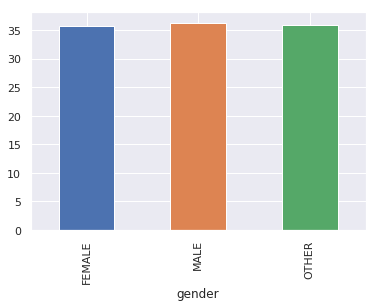

In [16]:
data_all.groupby('gender').age.mean().plot(kind='bar')

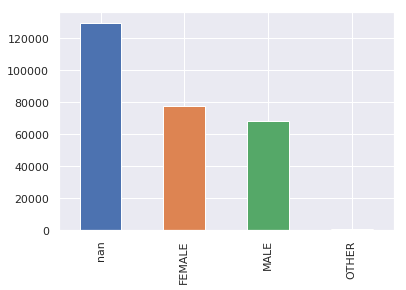

In [17]:
data_all.gender.value_counts(dropna=False).plot(kind='bar')

**Yearly growth of number of accounts created**

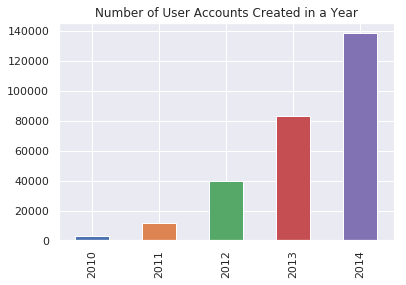

In [18]:
data_all.dac_year.value_counts(sort=False).plot(kind='bar', title='Number of User Accounts Created in a Year')

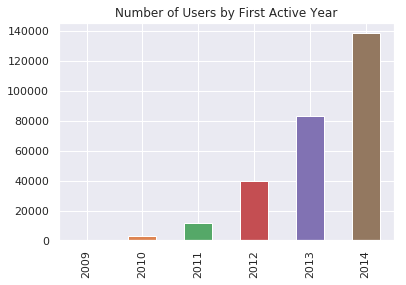

In [19]:
data_all.tfa_year.value_counts(sort=False).plot(kind='bar', title = 'Number of Users by First Active Year')

**Countries visited by Air BnB Users**

It looks for bulk of data there is no country desitnation specified. Second most visited place by users of Air BnB users is United States. 

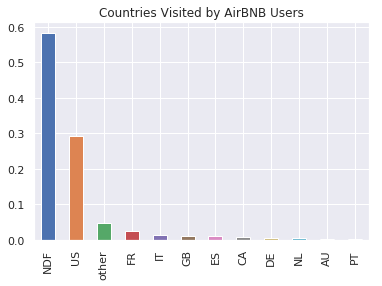

In [20]:
data_train.country_destination.value_counts(normalize=True).plot(kind='bar',title='Countries Visited by AirBNB Users')

**Number of Users by Language**

It looks like most users are English speaks. 

In [21]:
data_all.language.value_counts(sort=True)

en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
pl               75
da               75
no               51
cs               49
el               30
th               28
hu               25
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
Name: language, dtype: int64

In [22]:
#Note no null data now left
print(data_all.isnull().sum())

gender                     129480
age                        119744
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser               44394
dac_year                        0
dac_month                       0
dac_day                         0
tfa_year                        0
tfa_month                       0
tfa_day                         0
dtype: int64


**Preprocessing Data 
**

*Normalizing Numerical Features*

Only numerical data of age, year, date, day is normalized

In [23]:
# Import sklearn.preprocessing.StandardScaler
#from sklearn.preprocessing import MinMaxScaler

# Initialize a MinMax scaler, then apply it to the numerical features
#scaler = MinMaxScaler()
#numerical = ['age','dac_year','dac_month','dac_day','tfa_year','tfa_month','tfa_day']
#data_all[numerical] = scaler.fit_transform(data_all[numerical])

# Create categorical columns
features = ['gender','signup_method','signup_flow','language','affiliate_channel','affiliate_provider',\
            'first_affiliate_tracked','signup_app','first_device_type','first_browser']

# get dummies
data_all = pd.get_dummies(data_all,columns=features)


In [24]:
data_all.describe()

,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_14,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,...,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IBrowse,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Nintendo Browser,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
count,155803.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,...,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000,275547.000000
mean,36.071186,2013.243828,6.457505,15.958969,2013.243341,6.457446,15.958845,0.281346,0.247540,0.001212,0.719376,0.271692,0.008848,0.000083,0.747938,0.003800,0.024972,0.032016,0.000004,0.000131,0.001092,0.001143,0.000007,0.040806,0.000015,0.000036,0.000040,0.000051,0.000715,0.023256,0.015707,0.108272,0.000004,0.000022,0.000178,0.000272,0.003546,0.000109,0.963676,0.004261,...,0.000007,0.000004,0.140321,0.000007,0.000004,0.000004,0.000004,0.089800,0.000428,0.000004,0.000051,0.000087,0.000004,0.000218,0.000232,0.107553,0.000011,0.000004,0.000004,0.000007,0.000827,0.000029,0.000015,0.000004,0.000004,0.000047,0.000004,0.000087,0.193441,0.000044,0.000624,0.000098,0.000007,0.000156,0.000004,0.000029,0.000007,0.000004,0.000051,0.000025
std,11.654972,0.921206,2.985339,8.757489,0.921756,2.985189,8.757084,0.449657,0.431584,0.034795,0.449305,0.444833,0.093646,0.009136,0.434198,0.061525,0.156040,0.176044,0.001905,0.011429,0.033033,0.033792,0.002694,0.197841,0.003810,0.006024,0.006318,0.007128,0.026729,0.150714,0.124339,0.310724,0.001905,0.004666,0.013334,0.016496,0.059440,0.010434,0.187096,0.065134,...,0.002694,0.001905,0.347320,0.002694,0.001905,0.001905,0.001905,0.285895,0.020690,0.001905,0.007128,0.009332,0.001905,0.014755,0.015239,0.309816,0.003300,0.001905,0.001905,0.002694,0.028753,0.005388,0.003810,0.001905,0.00

In [25]:
data_all.head()

,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_14,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,...,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IBrowse,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Nintendo Browser,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,NaN,2010,6,28,2009,3,19,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,2011,5,25,2009,5,23,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56.0,2010,9,28,2009,6,9,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,42.0,2011,12,5,2009,10,31,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,41.0,2010,9,14,2009,12,8,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# Splitting train and test for the classifier
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder

V = data_all.values
X_train = V[:Nrows_train]
X_test = V[Nrows_train:]

#Create labels
labler = LabelEncoder()
y = labler.fit_transform(labels)

# Implementation of the classifier (decision tree)
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=22,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.6, seed=0)               
xgb.fit(X_train, y)
y_pred = xgb.predict_proba(X_test) 

In [27]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_ids)):
    idx = test_ids[i]
    ids += [idx] * 5
    cts += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('submission.csv',index=False)